<a href="https://colab.research.google.com/github/itsmeismaill/CNN-Classifier/blob/main/CNN_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data', train=True, transform=transform, download=True)
test_data = datasets.MNIST(root='data', train=False, transform=transform)

In [4]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1)

Sets up **data loading** for the **MNIST dataset** using **PyTorch**. It **transforms** the **images** into **tensors** and **splits** the dataset into **training and testing sets**. The **training data** is **shuffled** while the **testing data** is **left unchanged**. **Data loaders** are created to **efficiently load batches** of data for **training and testing purposes**. This **setup prepares** the **MNIST dataset** for **use in training and evaluating deep learning models**, particularly **convolutional neural networks (CNNs)**, using **PyTorch**.


In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # 7x7 feature map size after pooling
        self.fc2 = nn.Linear(128, 10)  # 10 classes for digits 0-9

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)  # Flatten for fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN()

A **basic Convolutional Neural Network (CNN) model** for **digit recognition** on the **MNIST dataset**. It includes **two convolutional layers** for **feature extraction**, followed by **max-pooling layers** for **downsampling**. The **features** are then **flattened** and **passed through fully connected layers** for **classification into 10 digit classes**. **ReLU activation functions** are applied **throughout**, except for the **output layer** which **returns raw logits**. This **model instantiation** allows for **digit recognition tasks** on the **MNIST dataset**.


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
# Training loop
train_losses = []
for epoch in range(7):  # Adjust as needed
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.0402
Epoch [2/10], Loss: 0.0654
Epoch [3/10], Loss: 0.0158
Epoch [4/10], Loss: 0.0668
Epoch [5/10], Loss: 0.0114
Epoch [6/10], Loss: 0.0387
Epoch [7/10], Loss: 0.0456


In [8]:
import torch
from sklearn.metrics import f1_score, confusion_matrix

model.eval()
correct = 0
total = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

print(f"Accuracy on test data: {100 * correct / total:.2f}%")

# Calculate F1 Score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"F1 Score: {f1:.2f}")

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy on test data: 98.97%
F1 Score: 0.99
Confusion Matrix:
[[ 975    0    0    0    0    0    3    1    1    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   2    1 1024    0    0    0    0    3    2    0]
 [   1    0    0  999    0    2    0    0    7    1]
 [   0    0    0    0  975    0    2    0    0    5]
 [   2    0    0    6    0  866    7    1    7    3]
 [   3    1    1    0    1    1  947    0    4    0]
 [   0    4    6    1    0    0    0 1015    1    1]
 [   1    0    2    0    0    1    0    0  969    1]
 [   2    2    0    0    6    1    0    1    5  992]]


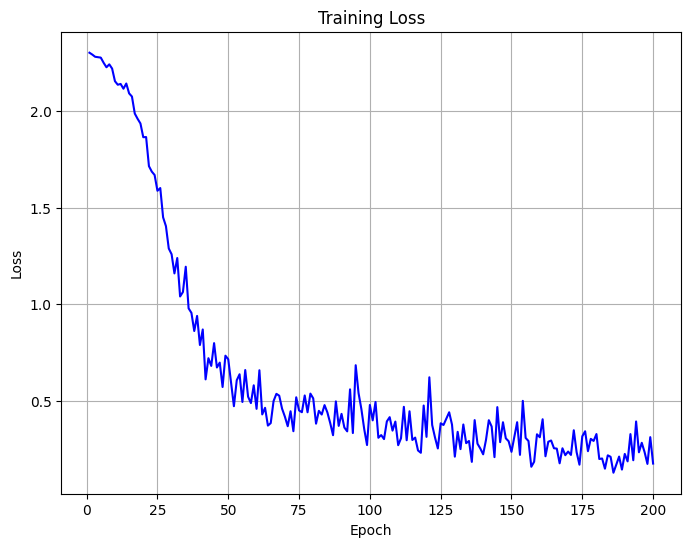

In [9]:
# Visualize training loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, 201), train_losses[:200], linestyle='-', color='b')  # Take the first 10 values
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()


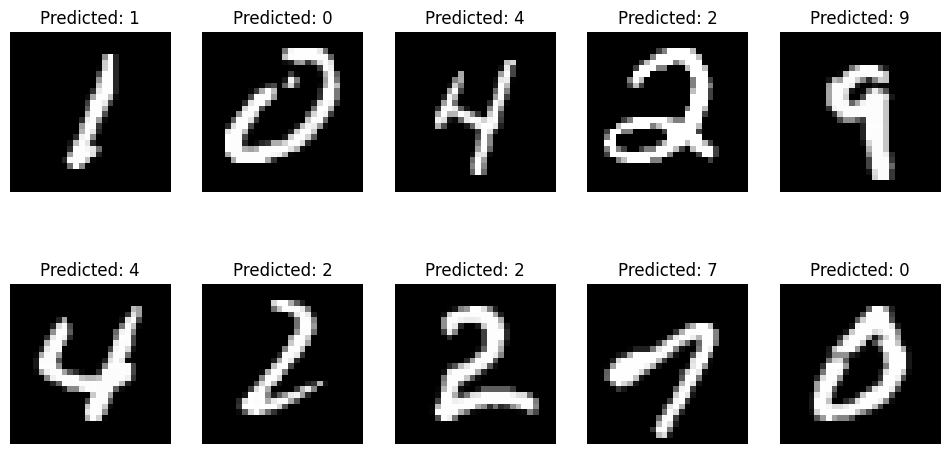

In [10]:
# Visualize model predictions
import matplotlib.pyplot as plt

# Get a batch of test data
images, labels = next(iter(test_loader))

# Move data to GPU if available


# Get model predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Plot images with predicted labels
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i][0].cpu(), cmap='gray')  # Move images to CPU for plotting
    plt.title(f"Predicted: {predicted[i].item()}")
    plt.axis('off')

plt.show()


In [11]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import numpy as np
import time
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [12]:
# Define the model architecture
class MNISTFasterRCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super(MNISTFasterRCNN, self).__init__()
        # Load a pre-trained ResNet-50 model and freeze its parameters
        self.backbone = torchvision.models.resnet50(pretrained=True)
        for param in self.backbone.parameters():
            param.requires_grad = False
        # Replace the classifier head with a custom one for MNIST
        self.backbone.conv1 = torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.backbone.fc = torch.nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

The **MNISTFasterRCNN model** is a **neural network architecture** tailored for **digit recognition** on the **MNIST dataset**. It **utilizes a pre-trained ResNet-50 backbone** with **frozen parameters** for **feature extraction**. The **fully connected layer** of ResNet-50 is **replaced with a custom linear layer** to **adapt the model for MNIST**, **outputting predictions** for the **specified number of classes**. The model's **forward method** **passes input data through the ResNet-50 backbone** and **returns the output**. **Overall**, MNISTFasterRCNN **combines the power of transfer learning** with **ResNet-50** and **custom modifications** to **efficiently recognize digits** in the **MNIST dataset**.


In [13]:
# Data preprocessing and loading
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [14]:
# Instantiate the model
model = MNISTFasterRCNN(num_classes=10)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 146MB/s]


MNISTFasterRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [15]:
start_time = time.time()
for epoch in range(1):  # Adjust the number of epochs as needed
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/5], Loss: {epoch_loss:.4f}")

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

Epoch [1/5], Loss: 0.3186
Training Time: 524.08 seconds


In [16]:
# Evaluate the model
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9482
F1 Score: 0.9473
Confusion Matrix:
[[ 958    0    2    2    1    0    9    0    7    1]
 [   0 1127    3    1    1    0    2    1    0    0]
 [   7    2  942   31    2    1    4   25   17    1]
 [   3    0    7  977    0    1    0    6   16    0]
 [   2    7    3    0  947    0    9    5    5    4]
 [   2    0    9   45    5  753   17    4   56    1]
 [  12    8    3    1    2    1  922    0    9    0]
 [   1    8   13   10    5    0    1  984    0    6]
 [   5    1    1    1    5    0    3    1  954    3]
 [  18   10    7    2    7    2    1   22   22  918]]


The **Convolutional Neural Network (CNN)** achieves **higher accuracy**, **F1 score**, and **lower training time** than the **Faster R-CNN** for the **MNIST dataset** (digit detection) **primarily** because **CNNs** are **specifically designed** for **image classification tasks**.

While **Faster R-CNN** is **powerful for object detection** and **designed for a broader range of tasks** including **object localization**, it **requires more complex architectures and tuning**. In the case of **MNIST**, where the task is **primarily digit recognition**, the **simpler architecture** and **focused nature of CNNs** lead to **better performance**.



In [17]:
import torchvision.models as models
import torch.optim as optim
import time
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Define data transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit VGG16 and AlexNet input size
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to pseudo-RGB
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Load MNIST dataset
train_data = MNIST(root='./data', train=True, transform=transform, download=True)
test_data = MNIST(root='./data', train=False, transform=transform)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=100)

# Define function for fine-tuning
def fine_tune_model(model, train_loader, test_loader, num_epochs=1):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Training the model
    start_time = time.time()

    for epoch in range(num_epochs):

        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print('Epoch %d, Loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))

    print('Finished Training')
    print('Training time:', time.time() - start_time)

    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy of the network on the 10000 test images: %d %%' % accuracy)
    return accuracy

# Load VGG16 model
model_vgg16 = models.vgg16(pretrained=True)
num_features = model_vgg16.classifier[6].in_features
model_vgg16.classifier[6] = nn.Linear(num_features, 10)  # Change the last fully connected layer for 10 classes

# Load AlexNet model
model_alexnet = models.alexnet(pretrained=True)
model_alexnet.classifier[6] = nn.Linear(4096, 10)  # Change the last fully connected layer for 10 classes

# Fine-tune VGG16
print("\nFine-tuning VGG16...")
vgg16_accuracy = fine_tune_model(model_vgg16, train_loader, test_loader)

# Fine-tune AlexNet
print("\nFine-tuning AlexNet...")
alexnet_accuracy = fine_tune_model(model_alexnet, train_loader, test_loader)

# Compare accuracies
print("\nAccuracy comparison:")
print("VGG16 accuracy:", vgg16_accuracy)
print("AlexNet accuracy:", alexnet_accuracy)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  w


Fine-tuning VGG16...
Epoch 1, Loss: 0.152
Finished Training
Training time: 989.6500742435455
Accuracy of the network on the 10000 test images: 99 %

Fine-tuning AlexNet...
Epoch 1, Loss: 0.167
Finished Training
Training time: 163.55006504058838
Accuracy of the network on the 10000 test images: 98 %

Accuracy comparison:
VGG16 accuracy: 99.18
AlexNet accuracy: 98.95
